# Compare E3SM simulations
This notebook serves as a starting template for a "quicklooks" diagnostic tool to quickly plot a number of variables from an arbitrary number of simulations side by side. The hope is for this to expand and/or be branched from to add observational comparisons, and more rigorous or detailed comparisons. Most of the heavy lifting is done in separate modules contained in the directory where this notebook is executed from.

## Jupyter magic
Load some Jupyter magic to allow displaying plots in the notebook, and to handle reloading modules when we modify then with this notebook still running:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read data and calculate climatologies
Read in the data we want to work with. Right now, this notebook will allow us to read and compare an arbitrary number of simulations. We can probably easily extend this to read in observations too, just by applying the appropriate routines to map names in observation files to names in E3SM files. A possible modification to this would be to require only TWO cases at a time so that we can do difference plots, or maybe to handle this case automatically by calling either the "compare differences" or the "compare full" versions of the plotting/comparison scripts.

In [ ]:
# Define locations of archives
cases = ('CAM5', 'SP-CAM 1-mom', 'SP-CAM 2-mom', 'CAM3 MMF')
case_archives = {
    'CAM3 MMF': '/gscratch/bhillma/mmf/pnnl_mmf_run1',
    'SP-CAM 1-mom': '/gscratch/bhillma/spcam/archive/sp20-cosp.FSPCAMs-AMIP.f19_f19/atm/hist',
    'SP-CAM 2-mom': '/gscratch/bhillma/spcam/archive/sp20-cosp.FSPCAMm-AMIP.f19_f19.no-ecpp/atm/hist',
    'CAM5': '/gscratch/bhillma/spcam/archive/sp20-cosp.FC5-AMIP.f19_f19/atm/hist',
}

# Read data
from glob import glob
from e3sm_utils import read_files
datasets = {case: read_files(sorted(glob('%s/*.h0*.nc'%(case_archives[case]))))
            for case in cases}

/ascldap/users/bhillma/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:489: UserWarning: CF decoding is overwriting dtype on variable 'date_written'
  .format(name))
/ascldap/users/bhillma/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:489: UserWarning: CF decoding is overwriting dtype on variable 'time_written'
  .format(name))


Calculate monthly climatologies in a simple but unsophisticated way (TODO: implement seasonal climatologies as well):

In [ ]:
climos = {case: datasets[case].groupby('time.month').mean('time', keep_attrs=True)
          for case in cases}

## Map plots
Create map plots of column integrated or single-level fields. 

Note: right now this requires "data" to have associated with it a latitude and longitude coordinate, so I think that to handle data on unstructured grids we either need to package the latitude and longitude information with the data arrays, or pass them in separately.

Note: The ability to make difference plots here would be useful. This is easy enough to do, and `plot_utils` already contains a function to do this. However, using it will require limiting the number of cases compared to two, or doing some weird panel plots with differences.

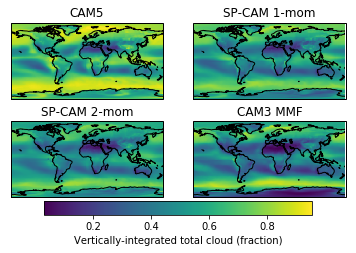

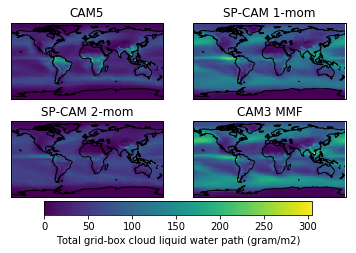

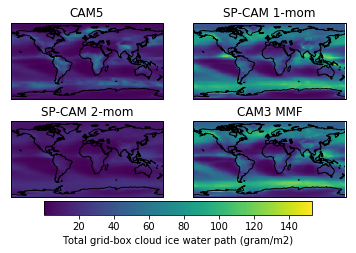

In [15]:
%matplotlib inline
from plot_utils import compare_maps
from e3sm_utils import get_data
variables = ('CLDTOT', 'TGCLDLWP', 'TGCLDIWP')
for variable_name in variables:
    data_arrays = [get_data(climos[case], variable_name).mean('month', keep_attrs=True)
                   for case in cases]
    figure = compare_maps(data_arrays, labels=cases, ncols=2, nrows=2)

## Zonal mean profiles

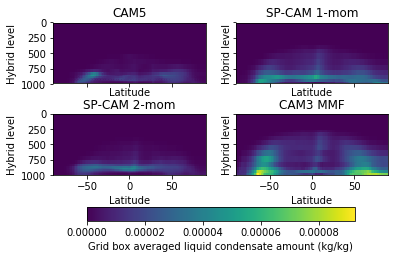

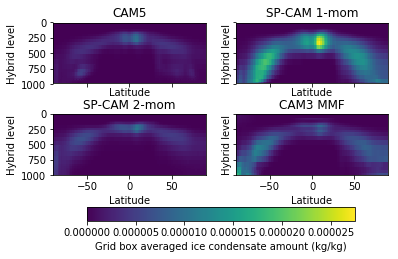

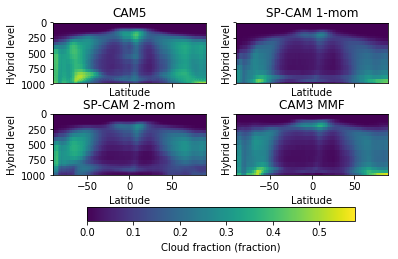

In [16]:
%matplotlib inline
variables = ('CLDLIQ', 'CLDICE', 'CLOUD')
from plot_utils import compare_zonal_profiles
for variable_name in variables:
    data_arrays = [get_data(climos[case], variable_name).mean(dim=('lon', 'month'), keep_attrs=True)
                   for case in cases]
    figure = compare_zonal_profiles(data_arrays, labels=cases, nrows=2, ncols=2)

## Zonal mean line plots

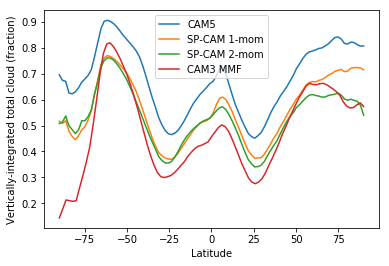

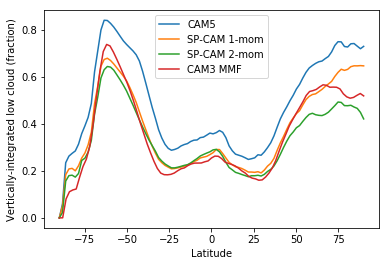

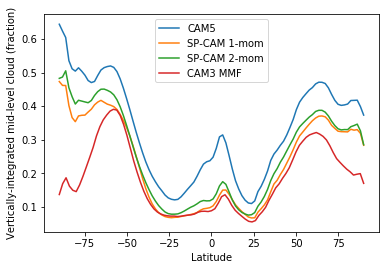

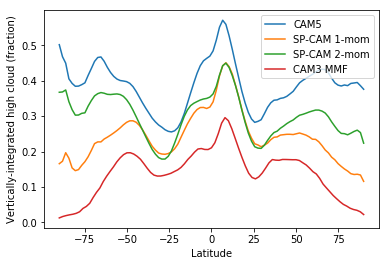

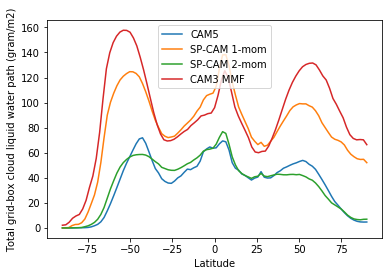

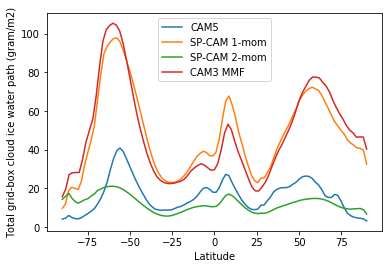

In [17]:
variables = ('CLDTOT', 'CLDLOW', 'CLDMED', 'CLDHGH', 'TGCLDLWP', 'TGCLDIWP')
from plot_utils import compare_zonal_means
for variable_name in variables:
    data_arrays = [get_data(climos[case], variable_name).mean(dim=('month', 'lon'), keep_attrs=True) 
                   for case in cases]
    figure = compare_zonal_means(data_arrays, labels=cases)

## Global mean profiles

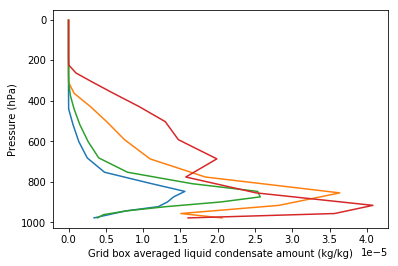

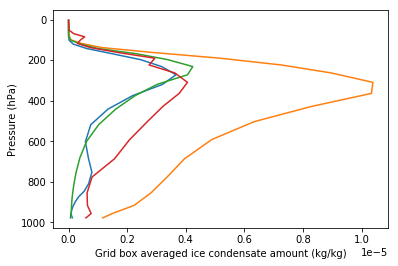

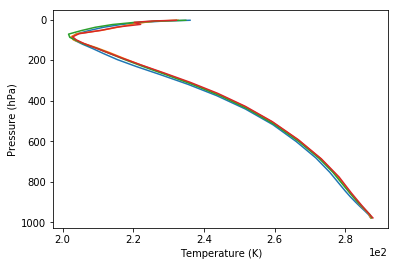

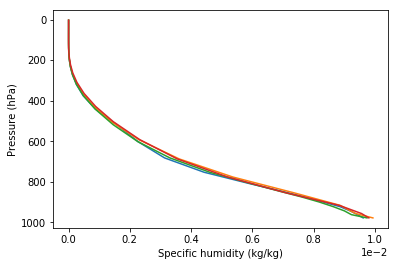

In [65]:
from matplotlib import pyplot
from e3sm_utils import get_pressure
from plot_utils import compare_profiles
cases = ('CAM5', 'SP-CAM 1-mom', 'SP-CAM 2-mom', 'CAM3 MMF')
for variable_name in ('CLDLIQ', 'CLDICE', 'T', 'Q'):
    data_arrays = [get_data(climos[case], variable_name).mean('month', keep_attrs=True).squeeze()
                   for case in cases]
    weights = [get_data(climos[case], 'gw').mean('month', keep_attrs=True) for case in cases]
    data_arrays = [area_average(data, weight, dims=('lat', 'lon')) 
                   for (data, weight) in zip(data_arrays, weights)]
    level_arrays = [area_average(get_pressure(climos[case]), weight, dims=('lat', 'lon')).squeeze() 
              for (case, weight) in zip(cases, weights)]
    figure = compare_profiles(data_arrays, level_arrays, labels=cases)